<a href="https://colab.research.google.com/github/HongJaeKwon/machine-learning/blob/master/GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import zipfile
import numpy as np
import os
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50;

<IPython.core.display.Javascript object>

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 0s 0us/step


In [ ]:
train_path = os.path.join(PATH, 'train')
validation_path = os.path.join(PATH, 'validation')

In [ ]:
original_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
original_generator = original_datagen.flow_from_directory(train_path, 
                                                          batch_size=128, 
                                                          target_size=(150, 150), 
                                                          class_mode='binary'
                                                         )

Found 2000 images belonging to 2 classes.


In [ ]:
training_generator = training_datagen.flow_from_directory(train_path, 
                                                          batch_size=128, 
                                                          shuffle=True,
                                                          target_size=(150, 150), 
                                                          class_mode='binary'
                                                         )

Found 2000 images belonging to 2 classes.


In [ ]:
validation_generator = training_datagen.flow_from_directory(validation_path, 
                                                            batch_size=128, 
                                                            shuffle=True,
                                                            target_size=(150, 150), 
                                                            class_mode='binary'
                                                           )

Found 1000 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
vgg_model=tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True)

553467904/553467096 [==============================] - 7s 0us/step


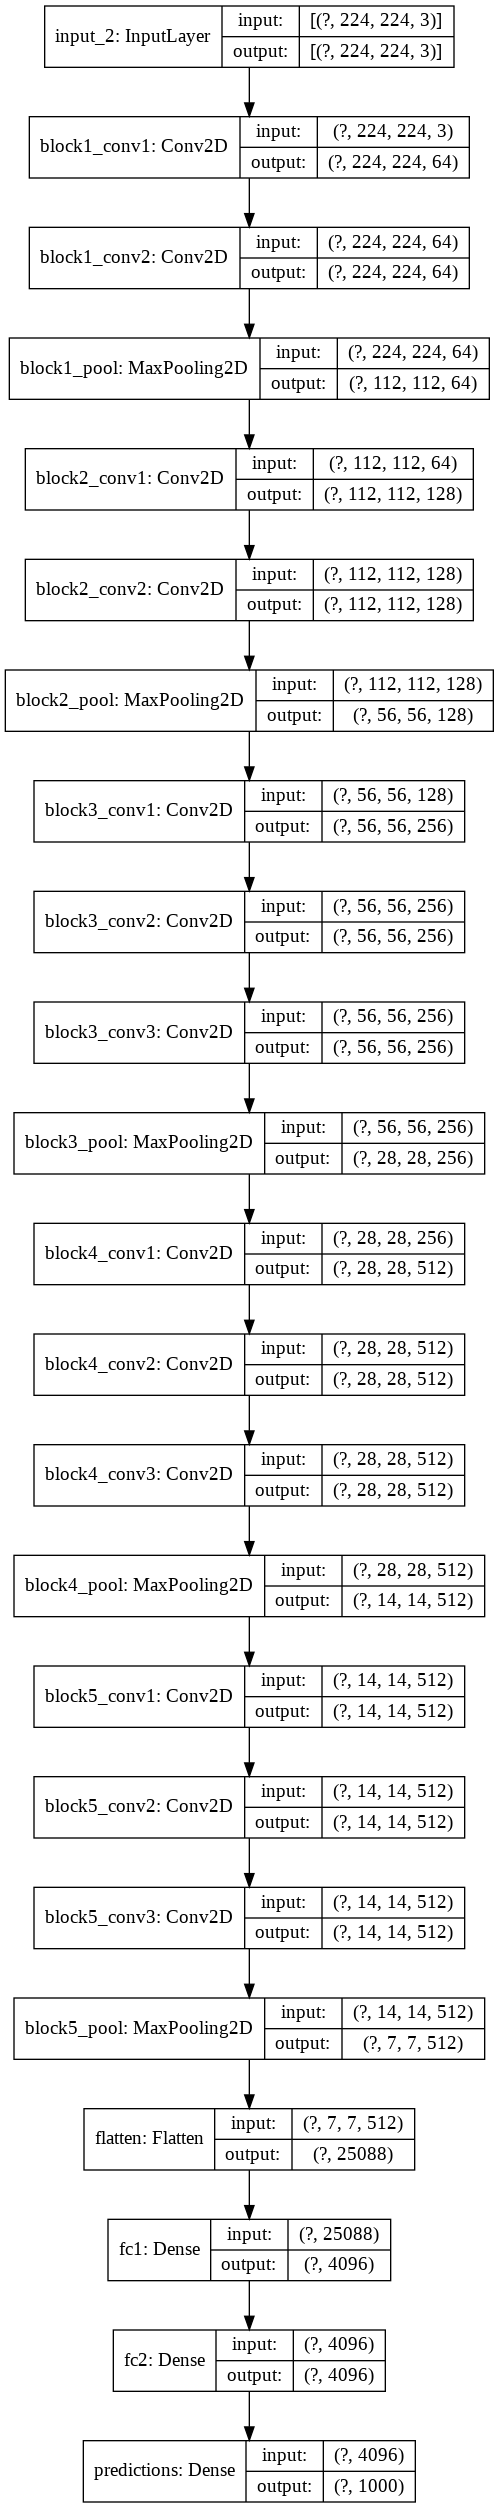

In [ ]:
tf.keras.utils.plot_model(vgg_model,show_shapes=True)

In [ ]:
grad_cam_model = tf.keras.models.Model([vgg_model.input], [vgg_model.get_layer('block5_conv3').output,vgg_model.output])

In [ ]:
img = cv2.imread('aa.jpg')
img = cv2.resize(img, (224, 224))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [ ]:
# 285: 'Egyptian cat'
# 173: 'Ibizan hound, Ibizan Podenco'
temp = np.array(predictions[0]).argsort()
temp[-2:]

array([173, 285])

In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_cam_model(np.reshape(img,(1,224,224,3)))
    loss = predictions[:, 285]

In [ ]:
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

In [ ]:
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

In [ ]:
weights = tf.reduce_mean(guided_grads, axis=(0, 1))

In [ ]:
cam = np.ones(output.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    cam += w * output[:, :, i]

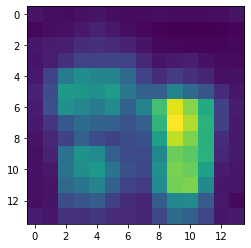

In [ ]:
plt.imshow(cam)

In [ ]:
cam = cv2.resize(cam.numpy(), (224, 224))

In [ ]:
grad_cam = np.maximum(grad_cam, 0)

In [ ]:
grad_cam = grad_cam / grad_cam.max()

In [ ]:
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

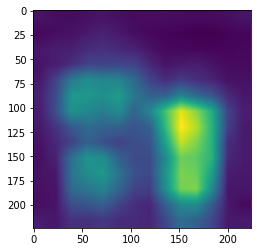

In [ ]:
plt.imshow(heatmap)

In [ ]:
cam = cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLOR_BGR2RGB)

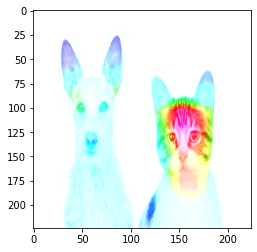

In [ ]:
plt.imshow(cv2.add(cam,img))

In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_cam_model(np.reshape(img,(1,224,224,3)))
    loss = predictions[:, 173]
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
weights = tf.reduce_mean(guided_grads, axis=(0, 1))
cam = np.ones(output.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    cam += w * output[:, :, i]
cam = cv2.resize(cam.numpy(), (224, 224))
grad_cam = np.maximum(grad_cam, 0)
grad_cam = grad_cam / grad_cam.max()
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

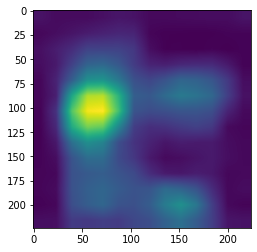

In [ ]:
plt.imshow(heatmap)

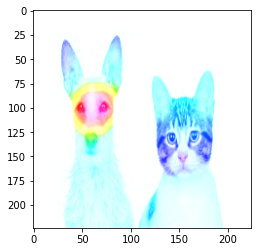

In [ ]:
cam = cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLOR_BGR2RGB)
plt.imshow(cv2.add(cam,img))